In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
from functools import partial
from scipy.integrate import quad
from singlelocusmodelextended import SingleLocusModelExt as Slme 

def meandiffT(self, fullarr, diffT):
        means0 = []
        means1 = []
        for j in range(len(fullarr)):
            update = np.array([True] * len(fullarr[j]))
            update[diffT[j]] = False
            if update.any(): 
                m0 = np.median(fullarr[j][update])
            else:
                m0 = 0    
            m1 = np.median(fullarr[j][~update])
            means0.append(m0)
            means1.append(m1)
        return means0, means1
    

In [2]:
def τ(w_i, w_j, x, y):
    """j invades i, starting at freq y and reaching freq x
    """
    return np.log((x * (1-y)) / ((1-x) * y)) / np.log(w_j / w_i)

def T(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=0, PLOT_N=False, PLOT_δ=False ):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - 2*((w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - 2*((w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - 2*((w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
    δ=np.array([δ])
    if δ.all() == 0:
        p_anmt_eumt = 1
    else: p_anmt_eumt = 1 - (1 - 2*((w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here...
    

    
    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # 
    τ_euwt_eumt = τ(w_euwt, w_eumt, x=0.95, y=np.maximum(x_0,1/N))
    # start with one or delta*N individuals  # why delta*N and not 2*s*delta*N
    τ_euwt_anwt = τ(w_euwt, w_anwt, x=1-1/N, y=np.maximum(δ, 1/N)) 
    # 
    τ_anwt_anmt = τ(w_anwt, w_anmt, x=1-1/N, y=np.maximum(μ2,1/N))
     # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ(w_anwt, w_eumt, x=0.95, y=np.maximum(δ, 1/N))
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        1/p_min 
        + 1/p_anwt_anmt 
        + 1/p_anmt_eumt 
        + τ_euwt_anwt  
#        + τ_anwt_anmt  # no fix of anmt, don't count
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    
    if PLOT_N:
        plt.plot(N, 1/p_min, label='T_min', color='blue')
        plt.plot(N, 1/p_anwt_anmt, label='T_anwt_anmt', color='orange' )
        plt.plot(N, 1/p_anmt_eumt, label='T_anmt_eumt', color='red' )
        plt.plot(N, τ_euwt_anwt, '--', label='τ_euwt_anwt', color='orange')
        plt.plot(N, τ_anwt_anmt, '--', label='τ_anwt_anmt', color='red')
        plt.plot(N, τ_anmt_eumt, '--', label='τ_anmt_eumt', color='purple')
        plt.legend()
#         plt.yscale('log')
        plt.xscale('log')
        plt.ylim(0, None)
        
    if PLOT_δ:
        plt.plot(δ, 1/p_min, label='T_min', color='blue')
        plt.plot(δ, [1/p_anwt_anmt for d in δ], label='T_anwt_anmt', color='orange' )
        plt.plot(δ, 1/p_anmt_eumt, label='T_anmt_eumt', color='red' )
        plt.plot(δ, τ_euwt_anwt, '--', label='τ_euwt_anwt', color='orange')
        plt.plot(δ, [τ_anwt_anmt for d in δ], '--', label='τ_anwt_anmt', color='red')
        plt.plot(δ, τ_anmt_eumt, '--', label='τ_anmt_eumt', color='purple')
        plt.legend()
#         plt.yscale('log')
        plt.xscale('log')
        plt.ylim(0, None)
    return T

In [3]:
def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0] #  limit=100

def mpintegral(f, N, s, a, b):
    f = partial(f, N, s)    
    return mp.quad(f, [a, b], verbose=False)

def I1(N, s, x):
    if x == 1:
        return 0
    S = 2*N*s
#     return np.expm1(S*x) * (np.exp(-S*x) - np.exp(-S)) / (x * (1-x)) # first term overflow so I rearranged:
    return (np.exp(-S) - np.exp(-S*x) - np.expm1(-S*(1-x))) / (x * (1-x))

def I2(N, s, x):
    if x == 0:
        return 0
    S = 2*N*s
    # use mp instad of np for high precision due to expm1(S*x)
    return -mp.expm1(S*x) * mp.expm1(-S*x) / (x * (1-x)) 

def p_kimura(N, s, x0=None):
    if x0 is None: x0 = 1 / N
    S = 2 * N * s
    numer = np.expm1(-S * x0)
    denom = np.expm1(-S)
    return numer / denom

@np.vectorize
def τ_kimura(N, w_i, w_j, x, y):
    """j invades i, starting at freq y and reaching freq x
    """
    s = (w_j - w_i) / w_i    
    x0, max_x, min_x = y, x, 0
    S = 2 * N * s
    J1 = -1.0 / (s * np.expm1(-S)) * integral(I1, N, s, x0, max_x)
    u = p_kimura(N, s, x0)
    # use mpintegral with mp.quad for high precision due to expm1(S*x) in I2
    J2 = -1.0 / (s * np.expm1(-S)) * mpintegral(I2, N, s, min_x, x0)
#     print(J1, J2, u, 1-u)
    return J1 + ((1 - u) / u) * J2 # eq 17 in Kimura & Ohta, Genetics 1969

In [4]:
def T_kimura(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=0):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - p_kimura(N, (w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - p_kimura(N, (w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
#     p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here but it doesnt seem to matter
    
    δ=np.array([δ])
    if δ.all() == 0:
        p_anmt_eumt = 1
    else: p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N  # N doesnt make sense here...
    

    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # τ_kimura(N, s, x0=None, max_x=1, min_x=0)
    τ_euwt_eumt = τ_kimura(N, w_euwt, w_eumt, x=0.95, y=np.maximum(x_0,1/N))
    # start with one or delta*N individuals
    τ_euwt_anwt = τ_kimura(N, w_euwt, w_anwt, x=1-1/N, y=np.maximum(δ, 1/N)) 
    # no fix of anmt, don't count
    # τ_anwt_anmt = τ_kimura(N, w_anwt, w_anmt, x=1-1/N, y=1/N)
    # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ_kimura(N, w_anwt, w_eumt, x=0.95, y=np.maximum(δ, 1/N))
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        # euwt->anwt
        1/p_min 
        + τ_euwt_anwt 
        # anwt->anmt
        + 1/p_anwt_anmt 
#         + τ_anwt_anmt  # no fix of anmt, don't count
        # anmt->eumt
        + 1/p_anmt_eumt
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    return T

## Population size

In [5]:
Nm58, msim_N_58 = np.load('msim_N_58.npy',allow_pickle=True)
Nm58 = Nm58.astype('float64')

dirmut = msim_N_58[1]
msim_N_58 = np.array([x for x in msim_N_58[0]])

In [6]:
msim_N_58.shape

(50, 100)

In [7]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = Nm58, 9.6e-08, 5.4e-4, 1, 1.021, 1.025, 1.028

In [8]:
T__ = T(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_ = T_kimura(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)

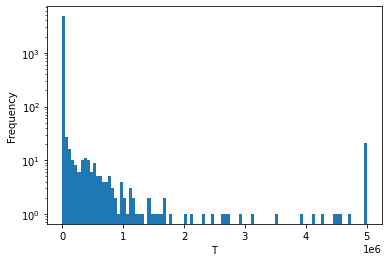

In [9]:
plt.hist((msim_N_58.ravel()), 100);
plt.xlabel('T')
plt.ylabel('Frequency')
#plt.xlim([1e6,5e6])
#plt.xscale('log')
plt.yscale('log');

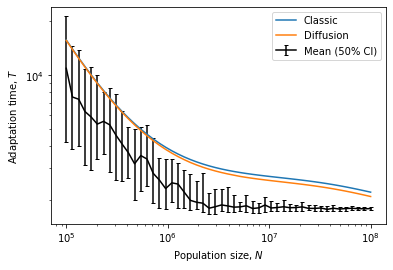

In [10]:
mean = np.median(msim_N_58, axis=1)
low = np.percentile(msim_N_58, 25, axis=1)
high = np.percentile(msim_N_58, 75, axis=1)
plt.errorbar(N, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(N, T__, label='Classic')
plt.plot(N, T_, label='Diffusion')


plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [11]:
nom, noa = meandiffT(_, msim_N_58, dirmut)

In [12]:
T__a = T(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_a = T_kimura(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)
T__m = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_m = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)

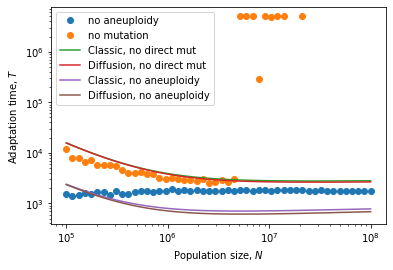

In [13]:
plt.plot(N, noa, 'o', label='no aneuploidy')
plt.plot(N, nom, 'o', label='no mutation')


plt.plot(N, T__a, label='Classic, no direct mut')
plt.plot(N, T_a, label='Diffusion, no direct mut')
plt.plot(N, T__m, label='Classic, no aneuploidy')
plt.plot(N, T_m, label='Diffusion, no aneuploidy')


plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [14]:
Nm58, msim_N_58_new=np.load('msim_N_58_new.npy',allow_pickle=True)
Nm58 = Nm58.astype('float64')

#msim_noaneuN58=np.array([x for x in msim_noaneuN_manu58[0]])
dirmut=msim_N_58_new[1]
msim_N_58_new=np.array([x for x in msim_N_58_new[0]])

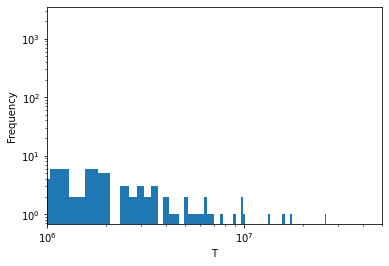

In [15]:
plt.hist((msim_N_58_new.ravel()), 100);
plt.xlabel('T')
plt.ylabel('Frequency')
plt.xlim([1e6,5e7])
plt.xscale('log')
plt.yscale('log');

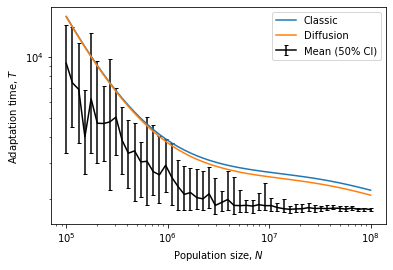

In [16]:
mean = np.median(msim_N_58_new, axis=1)
low = np.percentile(msim_N_58_new, 25, axis=1)
high = np.percentile(msim_N_58_new, 75, axis=1)
plt.errorbar(N, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(N, T__, label='Classic')
plt.plot(N, T_, label='Diffusion')


plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [17]:
nom, noa = meandiffT(_, msim_N_58_new, dirmut)

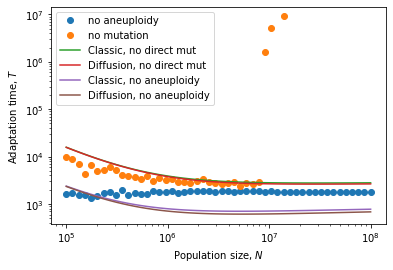

In [18]:
plt.plot(N, noa, 'o', label='no aneuploidy')
plt.plot(N, nom, 'o', label='no mutation')


plt.plot(N, T__a, label='Classic, no direct mut')
plt.plot(N, T_a, label='Diffusion, no direct mut')
plt.plot(N, T__m, label='Classic, no aneuploidy')
plt.plot(N, T_m, label='Diffusion, no aneuploidy')



plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [19]:
Nm58, msim_N_58_0 = np.load('msim_N_58_0.npy',allow_pickle=True)
Nm58 = Nm58.astype('float64')

#msim_noaneuN58=np.array([x for x in msim_noaneuN_manu58[0]])
dirmut=msim_N_58_0[1]
msim_N_58_0=np.array([x for x in msim_N_58_0[0]])

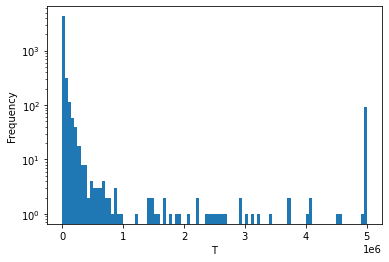

In [20]:
plt.hist((msim_N_58_0.ravel()), 100);
plt.xlabel('T')
plt.ylabel('Frequency')
#plt.xlim([1e6,5e6])
#plt.xscale('log')
plt.yscale('log');

In [21]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = Nm58, 1e-08, 5.4e-4, 1, 1.021, 1.025, 1.028

T__ = T(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_ = T_kimura(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)

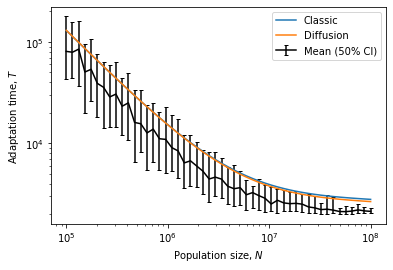

In [22]:
mean = np.median(msim_N_58_0, axis=1)
low = np.percentile(msim_N_58_0, 25, axis=1)
high = np.percentile(msim_N_58_0, 75, axis=1)
plt.errorbar(N, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(N, T__, label='Classic')
plt.plot(N, T_, label='Diffusion')


plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [23]:
nom, noa = meandiffT(_, msim_N_58_0, dirmut)

In [24]:
T__a = T(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_a = T_kimura(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)
T__m = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_m = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)

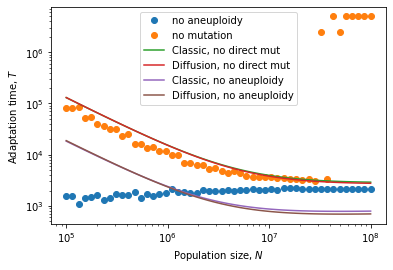

In [25]:
plt.plot(N, noa, 'o', label='no aneuploidy')
plt.plot(N, nom, 'o', label='no mutation')

plt.plot(N, T__a, label='Classic, no direct mut')
plt.plot(N, T_a, label='Diffusion, no direct mut')
plt.plot(N, T__m, label='Classic, no aneuploidy')
plt.plot(N, T_m, label='Diffusion, no aneuploidy')


plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [42]:
Nm58, msim_N_58_new2 = np.load('msim_N_58_new2.npy',allow_pickle=True)
Nm58 = Nm58.astype('float64')

dirmut=msim_N_58_new2[1]
msim_N_58_new2=np.array([x for x in msim_N_58_new2[0]])

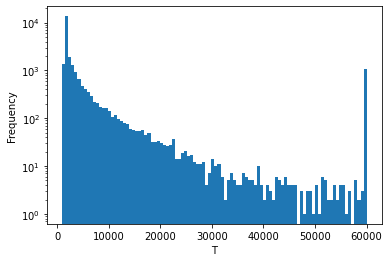

In [43]:
plt.hist((msim_N_58_new2.ravel()), 100);
plt.xlabel('T')
plt.ylabel('Frequency')
#plt.xlim([1e6,5e6])
#plt.xscale('log')
plt.yscale('log');

In [44]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = Nm58, 9.6e-08, 5.4e-4, 1, 1.021, 1.025, 1.028

T__ = T(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_ = T_kimura(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)

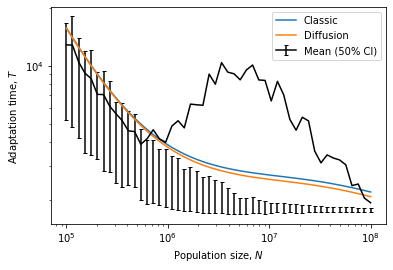

In [45]:
mean = np.mean(msim_N_58_new2, axis=1)
low = np.percentile(msim_N_58_new2, 25, axis=1)
high = np.percentile(msim_N_58_new2, 75, axis=1)
plt.errorbar(N, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(N, T__, label='Classic')
plt.plot(N, T_, label='Diffusion')


plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [72]:
Nm58, msim_N_58_manu = np.load('msim_N_58_manu.npy',allow_pickle=True)
Nm58 = Nm58.astype('float64')

dirmut=msim_N_58_manu[1]
msim_N_58_manu=np.array([x for x in msim_N_58_manu[0]])

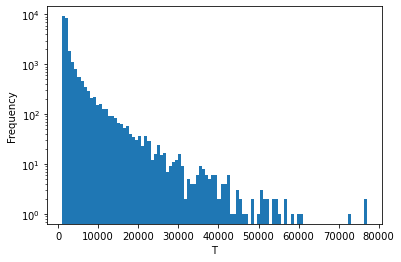

In [73]:
plt.hist((msim_N_58_manu.ravel()), 100);
plt.xlabel('T')
plt.ylabel('Frequency')
#plt.xlim([1e6,5e6])
#plt.xscale('log')
plt.yscale('log');

In [74]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = Nm58, 9.6e-08, 5.4e-4, 1, 1.021, 1.025, 1.028

T__ = T(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt , x_0=δ)
T_ = T_kimura(N, μ, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)

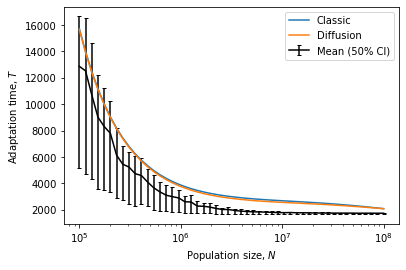

In [75]:
mean = np.mean(msim_N_58_manu, axis=1)
low = np.percentile(msim_N_58_manu, 25, axis=1)
high = np.percentile(msim_N_58_manu, 75, axis=1)
plt.errorbar(N, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(N, T__, label='Classic')
plt.plot(N, T_, label='Diffusion')


plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([1000,12000])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [76]:
nom, noa = meandiffT(_, msim_N_58_manu, dirmut)

C:\Users\aboas\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aboas\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [77]:
T__a = T(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_a = T_kimura(N, 0, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)
T__m = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_m = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)

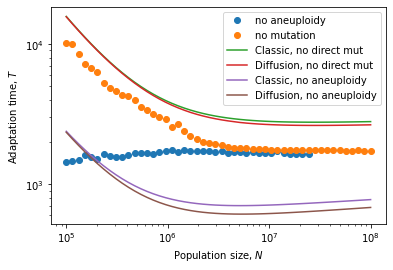

In [78]:
plt.plot(N, noa, 'o', label='no aneuploidy')
plt.plot(N, nom, 'o', label='no mutation')

plt.plot(N, T__a, label='Classic, no direct mut')
plt.plot(N, T_a, label='Diffusion, no direct mut')
plt.plot(N, T__m, label='Classic, no aneuploidy')
plt.plot(N, T_m, label='Diffusion, no aneuploidy')


plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();